In [126]:
import numpy as np
import scipy.io
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import log_loss
from sklearn.preprocessing import normalize
from sklearn.manifold import SpectralEmbedding
import torch
import torch.nn as nn
import torch.optim as optim
from lpproj import LocalityPreservingProjection 
import pennylane as qml
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding, BasisEmbedding, SqueezingEmbedding, DisplacementEmbedding, IQPEmbedding
from math import ceil
import pickle
import traceback

# 1. Load the data
We load the data from the .mat file and separate the features and labels

In [127]:
# Load data- This is the new balanced dataset
normal_samples = np.load('data/N_samples.npy')[:, 1, :]
normal_samples = np.concatenate((normal_samples, np.zeros((normal_samples.shape[0], 1))), axis=1)

premature_samples = np.load('data/V_samples.npy')[:, 1, :]
premature_samples = np.concatenate((premature_samples, np.ones((premature_samples.shape[0], 1))), axis=1)

dataset = np.concatenate((normal_samples[:premature_samples.shape[0]], premature_samples), axis=0)
np.random.shuffle(dataset)
x, y = dataset[:, : 320], dataset[:, -1]

In [ ]:
# generate an easy dataset for classification to make sure the model works
from sklearn.datasets import make_blobs
x, y = make_blobs(n_samples=1000, centers=2, n_features=256, random_state=1)
y = [float(i) for i in y]

# 2. Preprocess the data
In order to reduce the dimensionality of the data, we choose a preprocessing technique (PCA or a classical autoencoder) and apply it to the dataset. Alternatively, we can use no preprocessing technique and use all 400 features.

In [128]:
# define classical data preprocessing techniques
def pca(x, c):
    pca = PCA(n_components=c)
    x = pca.fit_transform(x)
    return x

def autoencoder(x, c, verbose=False):
    class Autoencoder(nn.Module):
        def __init__(self, input_dim, encoding_dim):
            super(Autoencoder, self).__init__()

            # Encoding layer
            self.encoder = nn.Linear(input_dim, encoding_dim)

            # Decoding layer
            self.decoder = nn.Linear(encoding_dim, input_dim)

        def forward(self, x):
            x = torch.relu(self.encoder(x))
            x = torch.sigmoid(self.decoder(x))
            return x

    input_dim = x.shape[1]  # Number of features in the input

    # Create the model
    model = Autoencoder(input_dim, c)

    # Loss function
    criterion = nn.MSELoss()

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Number of epochs
    num_epochs = 1000

    # Train the model
    x = torch.from_numpy(x).float()
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(x)
        loss = criterion(outputs, x)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch:{epoch + 1}, Loss:{loss.item()}')

    # Use the encoder to produce the encoded array
    encoded_x = model.encoder(x).data

    return encoded_x

def undersampling(x, c):
    indices = np.linspace(0, x.shape[1]-1, c).astype(int)
    x_undersampled = x[:, indices]
    
    assert x_undersampled.shape == (x.shape[0], c), x_undersampled.shape

    return x_undersampled

def laplacian_eigenmaps(x, c):
    embedding = SpectralEmbedding(n_components=c)
    x = embedding.fit_transform(x)
    return x

def locality_preserving_projections(x, c):
    embedding = LocalityPreservingProjection(n_components=c)
    x = embedding.fit_transform(x)
    return x

def compressive_sensing_fft(x, c):
    x_fft = fftshift(fft(x)) # compute the centered Fourier transform
    Xr = (10/8) * x_fft * np.random.permutation(np.repeat([0,0,1,1,1,1,1,1,1,1], x.shape[1]/10) ) # 10/8 is the scaling factor to make sure the amplitude is preserved
    Xr_no_zeros = [row[row.nonzero()] for row in Xr]
    Xr_2d = np.vstack(Xr_no_zeros)
    return Xr_2d

def compressive_sensing(x, c):
    phi = np.random.randn(256, 320)
    y = np.dot(phi, x.T)
    return y.T

selection = input('Please select the classical data preprocessing technique: \n 1. PCA \n 2. Autoencoder \n 3. Undersampling \n 4. Laplacian Eigenmaps \n 5. Locality Preserving Projections \n 6. Compressive sensing with FFT \n 7. Compressive sensing')
if selection == '1':
    c = int(input('Please enter the number of components (NOTE: to use amplitude encoding in the next step you must choose  a positive power of 2): '))
    x = pca(x, c)
elif selection == '2':
    c = int(input('Please enter the number of components (NOTE: to use amplitude encoding in the next step you must choose  a positive power of 2): '))
    x = autoencoder(x, c)
elif selection == '3':
    c = int(input('Please enter the number of components (NOTE: to use amplitude encoding in the next step you must choose  a positive power of 2): '))
    x = undersampling(x, c)
elif selection == '4':
    c = int(input('Please enter the number of components (NOTE: to use amplitude encoding in the next step you must choose  a positive power of 2): '))
    x = laplacian_eigenmaps(x, c)
elif selection == '5':
    c = int(input('Please enter the number of components (NOTE: to use amplitude encoding in the next step you must choose  a positive power of 2): '))
    x = locality_preserving_projections(x, c)
elif selection == '6':
    c = int(input('Please enter the number of components (NOTE: to use amplitude encoding in the next step you must choose  a positive power of 2): '))
    x = compressive_sensing_fft(x, c)
elif selection == '7':
    c = int(input('Please enter the number of components (NOTE: to use amplitude encoding in the next step you must choose  a positive power of 2): '))
    x = compressive_sensing(x, c)
print(x.shape)

(14016, 256)


# 3. Encode the data
Since we are working with a QCNN, we must embed the claassical data as a quantum state. We can choose between an angle embedding, a basis embedding, a displacement embedding, an IQP embedding, and a Squeezing embedding

In [131]:
def FRQI(datapoints, wires):
    for wire in wires[:-1]:
        qml.Hadamard(wires=wire)
    controls = [i for i in range(len(wires) - 1)] # num_qubits-1

    for pos in range(len(datapoints)):
        bin = format(pos, '08b')
        clist = []
        for i in bin:
            clist.append(int(i))
        # set up the x's corresponding to the clist
        for i in range(len(clist)):
            if clist[i] == 0:
                qml.PauliX(controls[i])

        # apply the controlled phase gate
        qml.ctrl(qml.RY(phi=2*datapoints[pos], wires=wires[-1]), control=controls)

        # undo the x's
        for i in range(len(clist)):
            if clist[i] == 0:
                qml.PauliX(controls[i])

selection = input('Please select the quantum feature map: \n 1. Angle Embedding \n 2. Amplitude Embedding \n 3. FRQI')
if selection == '1':
    n_qubits = x.shape[1]
    embedding = AngleEmbedding
elif selection == '2':
    n_qubits = int(np.log2(x.shape[1]))
    x = normalize(x)
    embedding = AmplitudeEmbedding
elif selection == '3':
    n_qubits = 9
    x = normalize(x)
    embedding = FRQI

# set up the quantum device
dev = qml.device('default.qubit', wires = n_qubits)

# train test split
split = 0.8*x.shape[0]
train_x, train_y = x[:int(split), :], y[:int(split)]
test_x, test_y = x[int(split):, :], y[int(split):]

# 4. Choose convolutional layer architecture
There have been numerous proposed convolutional layer architectures, collected here.

In [ ]:
def conv1(params, wires):
    qml.RZ(-np.pi/2, wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RZ(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RZ(np.pi/2, wires=wires[0])

def conv2(params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[0])
    qml.RZ(params[2], wires=wires[0])
    qml.RX(params[3], wires=wires[1])
    qml.RY(params[4], wires=wires[1])
    qml.RZ(params[5], wires=wires[1])
    qml.IsingZZ(params[6], wires=[wires[0], wires[1]])
    qml.IsingYY(params[7], wires=[wires[0], wires[1]])
    qml.IsingXX(params[8], wires=[wires[0], wires[1]])
    qml.RX(params[9], wires=wires[0])
    qml.RY(params[10], wires=wires[0])
    qml.RZ(params[11], wires=wires[0])
    qml.RX(params[12], wires=wires[1])
    qml.RY(params[13], wires=wires[1])
    qml.RZ(params[14], wires=wires[1])

def conv3(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

def conv4(params, wires):
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])
    qml.CZ(wires=[wires[0], wires[1]])
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])

def conv5(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

def conv6(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRZ(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])

def conv7(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRX(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRX(params[5], wires=[wires[0], wires[1]])

def conv8(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[4], wires=wires[0])
    qml.RY(params[5], wires=wires[1])

def conv9(params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRZ(params[4], wires=[wires[1], wires[0]])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])

def conv10(params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRX(params[4], wires=[wires[1], wires[0]])
    qml.CRX(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])

def conv11(params, wires):
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])

params_per_conv_layer_map = {
    1: 3,
    2: 15,
    3: 2,
    4: 2,
    5: 4,
    6: 6,
    7: 6,
    8: 6,
    9: 10,
    10: 10,
    11: 15
}
conv_selection = input("Select the convolutional layer you want to use (1-11): ")
conv = globals()[f"conv{conv_selection}"]
params_per_conv = params_per_conv_layer_map[int(conv_selection)]
print(params_per_conv)

# 5. Choose pooling architecture

In [ ]:
# taken from https://qiskit.org/ecosystem/machine-learning/tutorials/11_quantum_convolutional_neural_networks.html
def pool1(params, wires):
    qml.RZ(-np.pi/2, wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RZ(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[1])

# taken from https://www.tensorflow.org/quantum/tutorials/qcnn
def pool2(params, wires):
    qml.RX(params[0], wires=wires[1])
    qml.RY(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[1])
    qml.RX(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[0])
    qml.RZ(params[5], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RZ(-params[6], wires=wires[1])
    qml.RY(-params[7], wires=wires[1])
    qml.RX(-params[8], wires=wires[1])

# taken from https://arxiv.org/abs/2108.00661
def pool3(params, wires):
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])

# inspired by https://www.nature.com/articles/s41567-019-0648-8
def pool4(params, wires):
    measurement = qml.measure(wires=wires[0])
    qml.cond(measurement==0, qml.RZ)(params[0], wires=wires[1])

params_per_pool_layer_map = {
    1: 3,
    2: 9,
    3: 2,
    4: 1
}
pooling_selection = input("Select the pooling layer you want to use (1-4): ")
pool = globals()[f"pool{pooling_selection}"]
params_per_pool = params_per_pool_layer_map[int(pooling_selection)]

# 6. Construct the QCNN

In [ ]:
def pooling_layer(sources, sinks, params):
    param_index = 0
    for source, sink in zip(sources, sinks):
        pool(params[param_index:param_index+params_per_pool], wires=[source, sink])
        param_index += params_per_pool

inv_mapping = {
    1:4,
    2:2,
    4:1,
}

def pooling_layer_other(sources, sinks, params):
    measurements = [np.nan for i in range(8)]
    for i in sources:
        measurements[i] = qml.measure(wires=i)
    print(f"sources: {sources} | sinks: {sinks} | measurements: {measurements}")
    if len(sources) > 1:
        for count, j in enumerate(sinks):
            qml.cond(measurements[j-inv_mapping[len(sources)]] == 1, qml.RZ)(params[count], wires=j)
            qml.cond(measurements[j+inv_mapping[len(sources)]] == 1, qml.RZ)(params[count], wires=j)
    else:
        qml.cond(measurements[4] == 1, qml.RZ)(params[0], wires=sinks[0])

def conv_layer(wires, params, convs_per_layer):
    param_index = 0

    for i in range(convs_per_layer):
        for q1, q2 in zip(wires[::2], wires[1::2]):
            conv(params[param_index:param_index+params_per_conv], wires=[q1, q2])
            param_index += params_per_conv
        for q1, q2 in zip(wires[1::2], wires[2::2] + [min(wires)]):
            conv(params[param_index:param_index+params_per_conv], wires=[q1, q2])
            param_index += params_per_conv

    # # 3 skip convs
    # if len(wires) > 2:
    #     for q1, q2 in zip(wires[::3], wires[2::3] + [0]):
    #         conv(params[param_index:param_index+params_per_conv], wires=[q1, q2])
    #         param_index += params_per_conv

    #     for q1, q2 in zip(wires[1::3], wires[3::3] + [1]):
    #         conv(params[param_index:param_index+params_per_conv], wires=[q1, q2])
    #         param_index += params_per_conv

    #     for q1, q2 in zip(wires[2::3], wires[4::3]):
    #         conv(params[param_index:param_index+params_per_conv], wires=[q1, q2])
    #         param_index += params_per_conv

convs_per_layer = int(input("Select the number of covolutions per layer you want to use (1-3): "))

assert convs_per_layer in [1, 2, 3], "You must select 1, 2, or 3 convolutions per layer"

In [ ]:
special_pooling = bool(int(input("Enter 1 if you want to use pooling_layer_other, which checks if either nearest measured neighbor qubit evaluated to 1. Otherwise enter 0. WARNING: Not compatible with FRQI due to odd number of qubits")))
if special_pooling:
    pooling_direction = 2
    params_per_pool = 1
else:
    pooling_direction = int(input("Select the pooling direction (0 for removing top half, 1 for removing every other):"))
    assert pooling_direction in [0, 1], "Invalid pooling direction"

layers = [n_qubits] + [int(n_qubits/(2**i)) for i in range(1, int(np.log2(n_qubits))+1)]
num_params = ceil(sum(layers)*(params_per_conv*convs_per_layer + params_per_pool/2))

# list of tensors with initial values of 0.01*np.random.randn(num_params)
param_init = [torch.tensor(np.random.rand(), requires_grad=True) for _ in range(num_params)]

@qml.qnode(dev, interface='torch')
def circuit(params, x):
    embedding(x, wires=range(n_qubits))
    
    # create a list, starting with n_qubits, then floor(n_qubits/2), then floor(n_qubits/4), etc.
    layers = [n_qubits] + [int(n_qubits/(2**i)) for i in range(1, int(np.log2(n_qubits))+1)]

    param_starting_index = 0
    if pooling_direction == 0:
        # Shrinking towards the bottom
        for layer_qubits in layers[:-1]:
            conv_layer(wires=list(range(n_qubits - layer_qubits, n_qubits)), params=params[param_starting_index:param_starting_index+params_per_conv*int(layer_qubits*convs_per_layer)], convs_per_layer=convs_per_layer)
            param_starting_index += params_per_conv*int(layer_qubits*convs_per_layer)
            qml.Barrier()
            pooling_layer(sources=list(range(n_qubits - layer_qubits, n_qubits - layer_qubits + int(layer_qubits/2))), sinks=list(range(n_qubits - layer_qubits + int(layer_qubits/2), n_qubits)), params=params[param_starting_index:param_starting_index+params_per_pool*int(layer_qubits/2)])
            param_starting_index += params_per_pool*int(layer_qubits/2)
            qml.Barrier()

        return qml.expval(qml.PauliZ(n_qubits - 1))
    else:
        # Shrinking every other qubit
        source_factor = 1
        for layer_qubits in layers[:-1]:
            conv_layer(wires=list(range(0, n_qubits, n_qubits//layer_qubits)), params=params[param_starting_index:param_starting_index+params_per_conv*int(layer_qubits*convs_per_layer)], convs_per_layer=convs_per_layer)
            param_starting_index += params_per_conv*int(layer_qubits*convs_per_layer)
            qml.Barrier()
            if special_pooling:
                pooling_layer_other(sources=list(range(source_factor, n_qubits, 2*(n_qubits//layer_qubits))), sinks=list(range(0, n_qubits, 2*(n_qubits//layer_qubits))), params=params[param_starting_index:param_starting_index+params_per_pool*int(layer_qubits/2)])
            else:
                pooling_layer(sources=list(range(source_factor, n_qubits, 2*(n_qubits//layer_qubits))), sinks=list(range(0, n_qubits, 2*(n_qubits//layer_qubits))), params=params[param_starting_index:param_starting_index+params_per_pool*int(layer_qubits/2)])
            param_starting_index += params_per_pool*int(layer_qubits/2)
            source_factor *= 2
            qml.Barrier()

        return qml.expval(qml.PauliZ(0))

# print(qml.draw(circuit)(param_init, x[0]))
with open('circuit.txt', 'w') as f:
    try:
        f.write(qml.draw(circuit)(param_init, x[0]))
    except Exception as e:
        print(str(e))
        f.write(traceback.format_exc())

# 6B. Construct the MPS

In [134]:
pauli_x = torch.tensor([[0, 1], [1, 0]])
pauli_y = torch.tensor([[0, -1j], [1j, 0]])
pauli_z = torch.tensor([[1, 0], [0, -1]])
pauli_i = torch.tensor([[1, 0], [0, 1]])

mapping = {
    0: pauli_i,
    1: pauli_x,
    2: pauli_y,
    3: pauli_z
}

def block(weights, wires):
    weights.insert(0, torch.tensor([0.], requires_grad=False))
    matrices = []
    for i in range(4):
        for j in range(4):
            matrices.append(torch.kron(mapping[i], mapping[j])*weights[4*i+j])
    weight_matrix = sum(matrices)*(-1j/2)
    weight_matrix = torch.linalg.matrix_exp(weight_matrix)
    qml.QubitUnitary(weight_matrix, wires=wires)

# n_params_per_block = 15
# n_qubits = 9

# list of tensors with initial values of 0.01*np.random.randn(num_params)
param_init = [torch.tensor(np.random.rand(), requires_grad=True) for _ in range(2*(n_qubits-1)*15)]

@qml.qnode(dev, interface='torch')
def circuit(params, x):
    embedding(x, wires=range(n_qubits))
    for i in range(0, n_qubits-1):
        # print(f"{i*15}:{(i+1)*15}")
        block(params[i*15:(i+1)*15], wires=range(i, i+2))
    for i in range(0, n_qubits-1):
        # print(f"{i*15}:{(i+1)*15}")
        block(params[i*15:(i+1)*15], wires=range(i, i+2))
    return qml.expval(qml.PauliZ(7))

with open('circuit.txt', 'w') as f:
    try:#, x[0]
        f.write(qml.draw(circuit)(param_init, x[0]))
    except Exception as e:
        print(str(e))
        f.write(traceback.format_exc())

# 7. Train QCNN/MPS

In [135]:
from torcheval.metrics.functional import binary_accuracy
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
opt = optim.SGD(params=param_init, lr=0.001, nesterov=True, momentum=0.9)
loss = nn.BCELoss()
m = nn.Sigmoid()

def parallel_eval(weights, x):
    return m(circuit(weights, x))

def cost(weights, X, Y):
    if embedding == FRQI:
        with ThreadPoolExecutor(max_workers=20) as executor:
            futures = [executor.submit(parallel_eval, weights, x) for x in X]
            predictions = torch.stack([future.result() for future in as_completed(futures)])
            np_preds = [np.round(prediction.detach().numpy()) for prediction in predictions]
            train_acc = binary_accuracy(torch.tensor(np_preds, dtype=torch.int), torch.tensor(Y, dtype=torch.int))
            print("train_acc: {}".format(train_acc))
    else:
        predictions = m(circuit(weights, X))
    return loss(predictions, torch.tensor(Y, dtype=torch.double))

for i in range(3):
    # this will take a very long time to run for FRQI
    for iter, i in tqdm(enumerate(range(0, train_x.shape[0], 25)), total=train_x.shape[0]//25):
        opt.zero_grad()
        out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
        out.backward()
        opt.step()

    if embedding == FRQI:
        with ThreadPoolExecutor(max_workers=10) as executor:
            futures = [executor.submit(parallel_eval, param_init, x) for x in test_x]
            test_preds = [np.round(future.result().detach().numpy()) for future in tqdm(as_completed(futures), total=len(futures))]
    else:
        test_preds = np.round(m(circuit(param_init, test_x)).detach().numpy())
    accuracy = binary_accuracy(torch.tensor(test_preds, dtype=torch.int), torch.tensor(test_y, dtype=torch.int))
    print("Accuracy: {:0.5f}".format(accuracy))

  0%|          | 0/448 [00:00<?, ?it/s]

train_acc: 0.36000001430511475


  0%|          | 1/448 [00:10<1:18:41, 10.56s/it]


KeyboardInterrupt: 

# Train Classical CNN for comparison

In [136]:
import os
import random
from torcheval.metrics.functional import binary_accuracy, binary_f1_score
import tqdm


split = 0.8*x.shape[0]
train_x, train_y = x[:int(split), :], y[:int(split)]
test_x, test_y = x[int(split):, :], y[int(split):]

class My1DCNN(nn.Module):
    def __init__(self, size):
        super(My1DCNN, self).__init__()
        if size == 0:
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=2)# 40 trainable parameters # 258
            self.conv2 = nn.Conv1d(in_channels=10, out_channels=3, kernel_size=5, stride=1, padding=1)# 153 trainable parameters # 130
            self.conv3 = nn.Conv1d(in_channels=3, out_channels=2, kernel_size=3, stride=1, padding=1)# 16 trainable parameters # 66
            self.conv4 = nn.Conv1d(in_channels=2, out_channels=1, kernel_size=3, stride=1, padding=1)# 16 trainable parameters
            self.fc = nn.Linear(31, 1)
        elif size == 1:
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=2)# 40 trainable parameters # 258
            self.conv2 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)# 310 trainable parameters # 130
            self.conv3 = nn.Conv1d(in_channels=10, out_channels=3, kernel_size=3, stride=1, padding=1)# 153 trainable parameters
            self.conv4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1)# 16 trainable parameters
            self.fc = nn.Linear(32, 1)
        elif size == 2:
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=2)# 40 trainable parameters # 258
            self.conv2 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)# 310 trainable parameters # 130
            self.conv3 = nn.Conv1d(in_channels=10, out_channels=9, kernel_size=3, stride=1, padding=1)# 153 trainable parameters # 30
            self.conv4 = nn.Conv1d(in_channels=9, out_channels=1, kernel_size=5, stride=1, padding=1)# 153 trainable parameters
            self.fc = nn.Linear(30, 1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

accuracy_trials = []

for epoch in range(10):
    # Initialize the network
    net = My1DCNN(2)
    # print(torch.seed())
    # print(sum(p.numel() for p in net.parameters() if p.requires_grad))

    def cost(X, Y):
        predictions = net(torch.tensor(X, dtype=torch.float32).unsqueeze(1))
        return loss(predictions.squeeze(1), torch.tensor(Y, dtype=torch.float32))

    opt = optim.Adam(params=net.parameters(), lr=0.01) # the paper says that they found nesterov SGD to be better than Adam for the qcnn
    loss = nn.BCELoss()

    indices = np.random.choice(train_x.shape[0], train_x.shape[0], replace=False)
    train_x = train_x[indices]
    train_y = train_y[indices]

    # divide the data into batches of 25, per the paper
    accuracy_trial = []
    for iter, i in enumerate(range(0, train_x.shape[0], 25)):
        opt.zero_grad()
        out = cost(train_x[i:i+25], train_y[i:i+25])
        out.backward()
        opt.step()
        
        test_preds = np.round(net(torch.tensor(test_x, dtype=torch.float32).unsqueeze(1)).detach().numpy())
        test_y = np.array(test_y)
        accuracy = binary_accuracy(torch.tensor(test_preds, dtype=torch.int).squeeze(1), torch.tensor(test_y, dtype=torch.int))
        accuracy_trial.append(accuracy)
        print("Accuracy: {:0.5f}, Iter: {}".format(accuracy, iter))

    accuracy_trials.append(accuracy_trial)

with open("accuracy_trials_cnn.pkl", "wb") as f:
    pickle.dump(accuracy_trials, f)

accuracy_trials = np.array(accuracy_trials)
p25 = np.percentile(accuracy_trials, 25, axis=0)
p50 = np.percentile(accuracy_trials, 50, axis=0)
p75 = np.percentile(accuracy_trials, 75, axis=0)
time_steps = np.arange(accuracy_trials.shape[1])

plt.plot(time_steps, p25, label='25th percentile')
plt.plot(time_steps, p50, label='50th percentile')
plt.plot(time_steps, p75, label='75th percentile')

plt.fill_between(time_steps, p25, p75, color='gray', alpha=0.5)

plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()

plt.show()

Accuracy: 0.50499, Iter: 0
Accuracy: 0.50499, Iter: 1
Accuracy: 0.50499, Iter: 2
Accuracy: 0.50499, Iter: 3
Accuracy: 0.50499, Iter: 4
Accuracy: 0.50499, Iter: 5
Accuracy: 0.50499, Iter: 6
Accuracy: 0.50499, Iter: 7
Accuracy: 0.50499, Iter: 8
Accuracy: 0.50499, Iter: 9
Accuracy: 0.50499, Iter: 10
Accuracy: 0.50499, Iter: 11
Accuracy: 0.50499, Iter: 12
Accuracy: 0.50499, Iter: 13
Accuracy: 0.50499, Iter: 14
Accuracy: 0.50499, Iter: 15
Accuracy: 0.50499, Iter: 16
Accuracy: 0.50499, Iter: 17
Accuracy: 0.50499, Iter: 18
Accuracy: 0.50499, Iter: 19
Accuracy: 0.50499, Iter: 20


KeyboardInterrupt: 

# Compare with Classical FFN

Accuracy: 0.49501, Iter: 0
Accuracy: 0.49501, Iter: 1
Accuracy: 0.49501, Iter: 2
Accuracy: 0.49501, Iter: 3
Accuracy: 0.49501, Iter: 4
Accuracy: 0.49501, Iter: 5
Accuracy: 0.49501, Iter: 6
Accuracy: 0.49501, Iter: 7
Accuracy: 0.49501, Iter: 8
Accuracy: 0.49501, Iter: 9
Accuracy: 0.49501, Iter: 10
Accuracy: 0.49501, Iter: 11
Accuracy: 0.49501, Iter: 12
Accuracy: 0.49501, Iter: 13
Accuracy: 0.49501, Iter: 14
Accuracy: 0.49501, Iter: 15
Accuracy: 0.49501, Iter: 16
Accuracy: 0.49501, Iter: 17
Accuracy: 0.49501, Iter: 18
Accuracy: 0.49501, Iter: 19
Accuracy: 0.49501, Iter: 20
Accuracy: 0.49501, Iter: 21
Accuracy: 0.49501, Iter: 22
Accuracy: 0.49501, Iter: 23
Accuracy: 0.49501, Iter: 24
Accuracy: 0.49501, Iter: 25
Accuracy: 0.49501, Iter: 26
Accuracy: 0.49501, Iter: 27
Accuracy: 0.49501, Iter: 28
Accuracy: 0.49501, Iter: 29
Accuracy: 0.49501, Iter: 30
Accuracy: 0.49501, Iter: 31
Accuracy: 0.49501, Iter: 32
Accuracy: 0.49501, Iter: 33
Accuracy: 0.49501, Iter: 34
Accuracy: 0.49501, Iter: 35
Ac

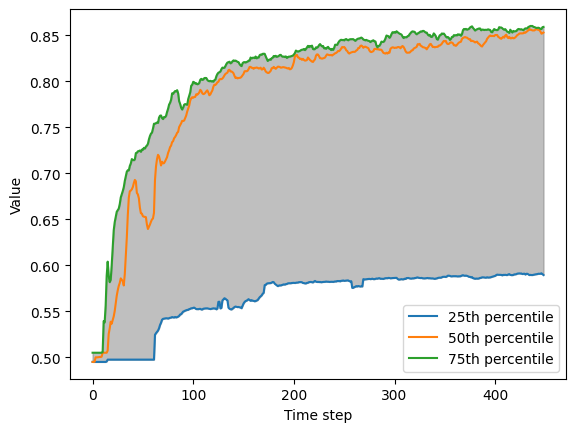

In [137]:
class MyFFN(nn.Module):
    def __init__(self, size):
        super(MyFFN, self).__init__()
        self.size = size
        self.sgmd = nn.Sigmoid()
        self.relu = nn.ReLU()

        if size == 0: #248 params
            self.fn1 = nn.Linear(256, 1)
        elif size == 1: # 473 params
            self.fn1 = nn.Linear(256, 2)
            self.fn2 = nn.Linear(2, 1)
        elif size == 2: # 698 params
            self.fn1 = nn.Linear(256, 3)
            self.fn2 = nn.Linear(3, 2)
            self.fn3 = nn.Linear(2, 1)

    def forward(self, x):
        if self.size == 0:
            x = self.fn1(x)
        elif self.size == 1:
            x = self.fn1(x)
            x = self.relu(x)
            x = self.fn2(x)
        elif self.size == 2:
            x = self.fn1(x)
            x = self.relu(x)
            x = self.fn2(x)
            x = self.relu(x)
            x = self.fn3(x)
        x = self.sgmd(x)
        return x
    
accuracy_trials = []

for epoch in range(10):
    # Initialize the network
    net = MyFFN(2)
    # print(sum(p.numel() for p in net.parameters() if p.requires_grad))

    opt = optim.Adam(params=net.parameters(), lr=0.01) # the paper says that they found nesterov SGD to be better than Adam for the qcnn
    loss = nn.BCELoss()
    # pos_weight = torch.ones([1]) * 9 # adjust the weight to control the penalty, the value should be more than 1 to penalize false negatives more
    # loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    m = nn.Sigmoid()

    def cost(X, Y):
        predictions = net(torch.tensor(X, dtype=torch.float32))
        return loss(predictions.squeeze(1), torch.tensor(Y, dtype=torch.float32))
    
    indices = np.random.choice(train_x.shape[0], train_x.shape[0], replace=False)
    train_x = train_x[indices]
    train_y = train_y[indices]

    # divide the data into batches of 25, per the paper
    accuracy_trial = []
    for iter, i in enumerate(range(0, train_x.shape[0], 25)):
        opt.zero_grad()
        out = cost(train_x[i:i+25], train_y[i:i+25])
        out.backward()
        opt.step()

        # get test accuracy
        test_preds = np.round(net(torch.tensor(test_x, dtype=torch.float32)).detach().numpy())
        test_y = np.array(test_y)
        accuracy = binary_accuracy(torch.tensor(test_preds, dtype=torch.int).squeeze(1), torch.tensor(test_y, dtype=torch.int))
        accuracy_trial.append(accuracy)
        print("Accuracy: {:0.5f}, Iter: {}".format(accuracy, iter))

    accuracy_trials.append(accuracy_trial)

with open("accuracy_trials_ffn.pkl", "wb") as f:
    pickle.dump(accuracy_trials, f)

accuracy_trials = np.array(accuracy_trials)
p25 = np.percentile(accuracy_trials, 25, axis=0)
p50 = np.percentile(accuracy_trials, 50, axis=0)
p75 = np.percentile(accuracy_trials, 75, axis=0)
time_steps = np.arange(accuracy_trials.shape[1])

plt.plot(time_steps, p25, label='25th percentile')
plt.plot(time_steps, p50, label='50th percentile')
plt.plot(time_steps, p75, label='75th percentile')

plt.fill_between(time_steps, p25, p75, color='gray', alpha=0.5)

plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()

plt.show()

In [ ]:
with open("accuracy_trials_2.pkl", "rb") as f:
    accuracy_trials_qcnn = pickle.load(f)

with open("accuracy_trials_cnn.pkl", "rb") as f:
    accuracy_trials_cnn = pickle.load(f)

with open("accuracy_trials_ffn.pkl", "rb") as f:
    accuracy_trials_ffn = pickle.load(f)

accuracy_trials_qcnn = np.array(accuracy_trials_qcnn)
accuracy_trials_cnn = np.array(accuracy_trials_cnn)
accuracy_trials_ffn = np.array(accuracy_trials_ffn)

p25_qcnn = np.percentile(accuracy_trials_qcnn, 25, axis=0)
p50_qcnn = np.percentile(accuracy_trials_qcnn, 50, axis=0)
p75_qcnn = np.percentile(accuracy_trials_qcnn, 75, axis=0)
p25_cnn = np.percentile(accuracy_trials_cnn, 25, axis=0)
p50_cnn = np.percentile(accuracy_trials_cnn, 50, axis=0)
p75_cnn = np.percentile(accuracy_trials_cnn, 75, axis=0)
p25_ffn = np.percentile(accuracy_trials_ffn, 25, axis=0)
p50_ffn = np.percentile(accuracy_trials_ffn, 50, axis=0)
p75_ffn = np.percentile(accuracy_trials_ffn, 75, axis=0)

time_steps = np.arange(accuracy_trials_qcnn.shape[1])
# time_steps = np.arange(accuracy_trials_ffn.shape[1])

plt.plot(time_steps, p25_qcnn, color='b')
plt.plot(time_steps, p50_qcnn, color='b', label='QCNN')
plt.plot(time_steps, p75_qcnn, color='b')
plt.fill_between(time_steps, p25_qcnn, p75_qcnn, color='b', alpha=0.5)
plt.plot(time_steps, p25_cnn, color='r')
plt.plot(time_steps, p50_cnn, color='r', label='CNN')
plt.plot(time_steps, p75_cnn, color='r')
plt.fill_between(time_steps, p25_cnn, p75_cnn, color='orange', alpha=0.5)
plt.plot(time_steps, p25_ffn, color='g')
plt.plot(time_steps, p50_ffn, color='g', label='FFN')
plt.plot(time_steps, p75_ffn, color='g')
plt.fill_between(time_steps, p25_ffn, p75_ffn, color='g', alpha=0.5)

plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()

plt.show()

# Analyze experiment results

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# open experiment_out.csv 
df_qcnn = pd.read_csv("results/qnn_experiment_results.csv")
df_cnn = pd.read_csv("results/experiment_out_classical_cnn.csv")
df_ffn = pd.read_csv("results/experiment_out_classical_ffn.csv")

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15, 5))
fig.subplots_adjust(wspace=0.1)

# plt.ylabel('Preprocessing Method')
y_labels = ["PCA", "Autoencoder", "Undersampling", "Laplacian Eigenmap", "Locality Preserving Projection", "Compressive Sensing"]
# plt.yticks()

def custom_aggfunc(x):
    smallest_index = x.index.min()
    max_accuracy_idx = x.idxmax()
    max_accuracy = x.loc[max_accuracy_idx]
    idx_difference = max_accuracy_idx - smallest_index + 1
    return f'{max_accuracy:.2f} ({idx_difference})'
df_qcnn_0 = df_qcnn.pivot_table(index="Preprocess", columns="EmbeddingNum", values=["Accuracy"], aggfunc='max')
df_qcnn_1 = df_qcnn.pivot_table(index="Preprocess", columns="EmbeddingNum", values=["Accuracy"], aggfunc=custom_aggfunc)

# Ensure df1 contains string values
df_qcnn_1 = df_qcnn_1.astype(str)

# Convert df1 to a 2D array
annot_array = df_qcnn_1.to_numpy()

sns.heatmap(df_qcnn_0, ax=ax1, annot=annot_array, fmt="s", cmap="YlGnBu")
x_labels = ["Amplitude Encoding", "FRQI"]
ax1.set_title("QCNN")
ax1.set_xlabel("Encoding method")
ax1.set_ylabel("Preprocessing Method")
ax1.set_yticks(np.arange(len(y_labels))+0.5, y_labels, rotation=0)
ax1.set_xticks(np.arange(len(x_labels))+0.5, x_labels, rotation=0)

x_labels_classical = ["1", "2", "3"]

df_cnn = df_cnn.pivot_table(index="Preprocess", columns="Size", values=["Accuracy"], aggfunc='max')
sns.heatmap(df_cnn, ax=ax2, cmap="YlGnBu", annot=True)
ax2.set_xticks(np.arange(len(x_labels_classical))+0.5, x_labels_classical, rotation=0)
ax2.set_yticklabels([])
ax2.set_title("CNN")
ax2.set_xlabel("Size")
ax2.set_ylabel("")

df_ffn = df_ffn.pivot_table(index="Preprocess", columns="Size", values=["Accuracy"], aggfunc='max')
sns.heatmap(df_ffn, ax=ax3, cmap="YlGnBu", annot=True)
ax3.set_xticks(np.arange(len(x_labels_classical))+0.5, x_labels_classical, rotation=0)
ax3.set_yticklabels([])
ax3.set_title("FFN")
ax3.set_xlabel("Size")
ax3.set_ylabel("")
plt.show()

# df2 = df.pivot(index="Conv", columns="Pooling", values="F1")
# sns.heatmap(df2, annot=True, cmap="YlGnBu")
# plt.show()

In [ ]:
df_cnn = pd.read_csv("results/experiment_out_classical_cnn.csv")
df_ffn = pd.read_csv("results/experiment_out_classical_ffn.csv")

df_cnn = df_cnn.drop(columns=['F1'])
df_ffn = df_ffn.drop(columns=['F1'])

df_cnn = df_cnn.pivot_table(index="Preprocess", columns="Size", values=["Accuracy"], aggfunc='max')
sns.heatmap(df_cnn,cmap="YlGnBu", annot=True)
plt.show()

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.subplots_adjust(wspace=0.05)
sns.heatmap(df, cmap="rocket", ax=ax, cbar=False)